In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time

# --- Configuration ---
STATE_DIM = 2
CONTROL_DIM = 2
HIDDEN_DIM = 16

RHO_TIME_COST = 1 # cost of time
BETA = 1 # inverse weight for the cost of control
U_MAX = 3 # max value of u

T_FIXED_INIT = 5.0  # Initial value for fixed time horizon
T_FIXED_FACTOR = .999 # Factor to decrease fixed time horizon per "epoch"
T_FIXED_MIN = 2.0 # Minimum fixed time horizon allowed

W_TERMINAL_INIT = 10.0  # Initial value for terminal penalty
W_TERMINAL_FACTOR = .98 # Factor to decrease terminal penalty per "epoch"
W_TERMINAL_MIN = 10.0 # Minimum terminal penalty allowed

K_TANH_INIT = 1  # Initial value for k in tanh
K_TANH_FACTOR = 1.01 # Factor to increase k per "epoch"
K_TANH_MAX = 100 # Maximum k allowed

OPTIMIZATION_ITERATIONS = 5000 # Total iterations for optimizing theta
LEARNING_RATE = 5e-4
SEED = 123

TARGET_STATE = np.array([1.0, 1.0])
Y_FORCING = np.array([.0, .0]) # Constant external forcing y1, y2

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- Neural Network Controller (Unchanged) ---
class ControllerNN(nn.Module):
    # ... (Same as before)
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(STATE_DIM, HIDDEN_DIM)
        # self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, CONTROL_DIM)
        self.fc4 = nn.Tanh()

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        # h = torch.tanh(self.fc2(h))
        u = self.fc3(h) # Linear output for control
        u = self.fc4(u)
        return U_MAX*u

# --- Dynamics and Related Functions ---
# system_dynamics (Unchanged from previous version with Y_FORCING)
def system_dynamics(t, x, model, params_flat):
    offset = 0
    params_dict = {}
    params_flat_torch = torch.tensor(params_flat, dtype=torch.float32)
    for name, param in model.named_parameters():
        numel = param.numel()
        params_dict[name] = params_flat_torch[offset:offset+numel].view(param.shape).clone().requires_grad_(True)
        offset += numel
    original_state_dict = model.state_dict()
    model.load_state_dict(params_dict)
    x_tensor = torch.tensor(x, dtype=torch.float32).requires_grad_(True)
    u_tensor = model(x_tensor)
    dxdt = -x + Y_FORCING + u_tensor.detach().numpy()
    model.load_state_dict(original_state_dict)
    return dxdt

# Running Cost L_new function
def running_cost_L_new(x_t, u_t, k_tanh):
    target_t = torch.tensor(TARGET_STATE, dtype=torch.float32)
    dist_sq = torch.sum((x_t - target_t)**2)
    weight = torch.tanh(k_tanh * dist_sq)
    L_original = 1/BETA * torch.sum(u_t**2) + RHO_TIME_COST
    return weight * L_original

# MODIFIED Adjoint Dynamics
def adjoint_dynamics_tanh(t, p, x_interp, model, params_flat, k_tanh):
    x_t_np = x_interp(t)

    # --- Prepare tensors and model parameters ---
    x_t = torch.tensor(x_t_np, dtype=torch.float32).requires_grad_(True)
    p_t = torch.tensor(p, dtype=torch.float32)
    target_t = torch.tensor(TARGET_STATE, dtype=torch.float32)

    # Temporarily load params into model to compute u and its gradients
    offset = 0
    params_dict = {}
    params_list_for_grad = []
    params_flat_torch = torch.tensor(params_flat, dtype=torch.float32)
    for name, param in model.named_parameters():
        numel = param.numel()
        p_linked = params_flat_torch[offset:offset+numel].view(param.shape).clone().requires_grad_(True)
        params_dict[name] = p_linked
        params_list_for_grad.append(p_linked)
        offset += numel
    original_state_dict = model.state_dict()
    nn_model.load_state_dict(params_dict, strict=False)

    # --- Compute terms needed for dH/dx ---
    u_t = model(x_t)
    # L_original_val = 1/BETA * torch.sum(u_t**2) + RHO_TIME_COST
    # dist_sq = torch.sum((x_t - target_t)**2)
    # z = k_tanh * dist_sq
    # tanh_z = torch.tanh(z)
    # sech_sq_z = 1.0 - tanh_z**2

    # Calculate dL_new/dx using autograd for the u part
    # dL_new/dx = sech^2(z) * [2k(x-xt)] * L_orig + tanh(z) * (du/dx)^T u

    # L_new_val = tanh_z * L_original_val # Need this value eventually for H

    # Grad of first part w.r.t x: sech^2(z) * [2k(x-xt)] * L_orig

    # grad_L_term1 = sech_sq_z * (2.0 * k_tanh * (x_t - target_t)) * L_original_val.detach() # Treat L_orig as constant here

    # Grad of second part w.r.t x: tanh(z) * (du/dx)^T u
    # Compute VJP: grad_x ( tanh(z) * dot(u, u_detached) )
    # This is tricky because tanh(z) depends on x.
    # Let's use full autograd for dL_new/dx
    L_new_for_grad = running_cost_L_new(x_t, u_t, k_tanh)
    grad_L_new_x = grad(L_new_for_grad, x_t, retain_graph=True)[0]


    # Calculate p^T (df/dx)
    # f = -x + y + u
    # df/dx = -I + du/dx
    # p^T(df/dx) = p^T(-I + du/dx) = -p^T + p^T(du/dx)
    # Need VJP: grad_x ( p^T @ (-x + y + u) )
    f_val = -x_t + torch.tensor(Y_FORCING, dtype=torch.float32) + u_t
    pTf_term = torch.dot(p_t.detach(), f_val)
    grad_pTdf_dx = grad(pTf_term, x_t, retain_graph=True)[0] # This computes pT(-I + du/dx)

    # Calculate dH/dx = dL_new/dx + pT(df/dx)
    dH_dx = grad_L_new_x + grad_pTdf_dx

    # dp/dt = -(dH/dx)^T
    dpdt = -dH_dx.detach().numpy()

    # Restore original parameters
    nn_model.load_state_dict(original_state_dict)

    return dpdt

def functional_forward(x, params_list):
    """Performs the forward pass using a list of parameter tensors."""
    # Assumes params_list is in the order: fc1.weight, fc1.bias, fc2.weight, fc2.bias, fc3.weight, fc3.bias
    idx = 0
    w1 = params_list[idx]; idx+=1
    b1 = params_list[idx]; idx+=1
    # w2 = params_list[idx]; idx+=1
    # b2 = params_list[idx]; idx+=1
    w3 = params_list[idx]; idx+=1
    b3 = params_list[idx]; idx+=1

    h = torch.tanh(torch.nn.functional.linear(x, w1, b1))
    # h = torch.tanh(torch.nn.functional.linear(h, w2, b2))
    u = torch.nn.functional.linear(h, w3, b3)
    u = torch.tanh(u)
    return U_MAX*u

# Terminal constraint function psi(x) = x - target (Unchanged)
def terminal_constraint(x):
    return x - TARGET_STATE

# --- Main Optimization Loop ---
nn_model = ControllerNN()
optimizer = optim.Adam(nn_model.parameters(), lr=LEARNING_RATE)
k_tanh = K_TANH_INIT
W_TERMINAL = W_TERMINAL_INIT
T_FIXED = T_FIXED_INIT

# Store history for plotting
history = {'cost': [], 'term_constraint_norm': [], 'k_tanh': []}






In [89]:
print("Starting Optimization (Fixed Time Horizon)...")
start_opt_time = time.time()

for iteration in range(OPTIMIZATION_ITERATIONS):
    iter_start_time = time.time()
    optimizer.zero_grad()

    # Flatten parameters for ODE solver
    params_list = [p.detach().clone().requires_grad_(True) for p in nn_model.parameters()]
    params_flat_tensor = torch.cat([p.view(-1) for p in params_list])
    params_flat_np = params_flat_tensor.detach().numpy()

    # --- Forward Pass ---
    x0 = np.zeros(STATE_DIM)
    sol_forward = solve_ivp(
        system_dynamics,
        [0, T_FIXED], # Fixed time interval
        x0,
        args=(nn_model, params_flat_np),
        dense_output=True,
        rtol=1e-5, atol=1e-6
    )

    if sol_forward.status != 0: # Integration failed
        print(f"Iter {iteration+1}: Forward integration failed. Status: {sol_forward.status}. Skipping update.")
        # Optionally increase k here anyway? Or stop?
        # k_tanh *= K_TANH_FACTOR # Anneal k even on failure? Maybe not.
        continue # Skip rest of loop

    # --- Process Forward Solution ---
    T = T_FIXED
    x_T = sol_forward.y[:, -1]
    psi_T = terminal_constraint(x_T) # Check terminal constraint violation
    norm_psi_T = np.linalg.norm(psi_T)
    x_interp = sol_forward.sol

    # Calculate Total Cost (for reporting)
    t_eval_cost = np.linspace(0, T, num=100)
    x_eval_cost = x_interp(t_eval_cost)
    running_cost_int_val = 0.0
    with torch.no_grad():
        for i in range(len(t_eval_cost)):
            xi = x_eval_cost[:, i]
            xi_t = torch.tensor(xi, dtype=torch.float32)
            ui_t = nn_model(xi_t)
            L_new_val = running_cost_L_new(xi_t, ui_t, k_tanh)
            if i > 0:
                 dt = t_eval_cost[i] - t_eval_cost[i-1]
                 running_cost_int_val += L_new_val.item() * dt

    terminal_cost_val = W_TERMINAL * norm_psi_T**2
    total_cost_val = running_cost_int_val + terminal_cost_val

    # --- Backward Pass ---
    # Terminal condition p(T_fixed) = grad_x Phi_new = 2 * W_TERMINAL * (x(T) - target)
    pT = 2 * W_TERMINAL * psi_T

    sol_backward = solve_ivp(
        adjoint_dynamics_tanh,
        [T, 0], # Integrate backward from T_fixed to 0
        pT,
        args=(x_interp, nn_model, params_flat_np, k_tanh), # Pass k_tanh
        dense_output=True,
        rtol=1e-5, atol=1e-6
    )

    if sol_backward.status != 0: # Backward integration failed
        print(f"Iter {iteration+1}: Backward integration failed. Status: {sol_backward.status}. Skipping update.")
        # k_tanh *= K_TANH_FACTOR
        continue

    p_interp = sol_backward.sol

    # --- Gradient Calculation ---
    # Integrate d(TotalCost)/dtheta = integral[ (dNN/dtheta)^T * (dH/du) ] dt
    # H = L_new + pTf
    # dH/du = dL_new/du + pT(df/du)
    # dL_new/du = tanh(k*dist^2) * u
    # df/du = Identity
    # dH/du = tanh(k*dist^2)*u + p
    t_backward = np.linspace(T, 0, num=100)
    grad_total_theta = {name: torch.zeros_like(param) for name, param in nn_model.named_parameters()}

    # Create fresh parameter copies with requires_grad for this grad calc
    # Use nn_model.parameters() directly if graph handling is correct,
    # or stick with copies if needed for safety/clarity.
    # Let's use copies for now.
    params_list_grad = [p.detach().clone().requires_grad_(True) for p in nn_model.parameters()]

    # Create a name mapping to assign gradients back correctly
    param_names = list(nn_model.state_dict().keys())

    for i in range(len(t_backward) - 1):
        t_curr = t_backward[i]
        t_next = t_backward[i+1]
        dt_bw = t_next - t_curr # Negative

        x_curr_np = x_interp(t_curr)
        p_curr_np = p_interp(t_curr)
        x_curr_t = torch.tensor(x_curr_np, dtype=torch.float32).requires_grad_(True) # x might influence u
        p_curr_t = torch.tensor(p_curr_np, dtype=torch.float32)
        target_t = torch.tensor(TARGET_STATE, dtype=torch.float32)

        # --- Recompute u using functional forward pass ---
        # This ensures the graph connects x_curr_t and params_list_grad to u_curr_t
        u_curr_t = functional_forward(x_curr_t, params_list_grad)
        # --- End Recompute u ---

        # Calculate dH/du = tanh(k*dist^2)*u + p
        dist_sq = torch.sum((x_curr_t - target_t)**2)
        tanh_term = torch.tanh(k_tanh * dist_sq)
        dH_du_curr = tanh_term.detach() * u_curr_t + p_curr_t # Still treat tanh as constant w.r.t u for this partial

        # Calculate gradient of dot(dH/du, u) w.r.t. parameters theta
        term_to_grad = torch.dot(dH_du_curr.detach(), u_curr_t)

        # --- Compute gradients w.r.t the copies in params_list_grad ---
        # Set retain_graph=False as we don't need it further in this step
        # Set allow_unused=True just in case, although it shouldn't be needed now
        grads_list = grad(term_to_grad, params_list_grad, retain_graph=False, allow_unused=True)

        # Accumulate gradient contributions
        with torch.no_grad():
            for idx, name in enumerate(param_names): # Use names for assignment
                if grads_list[idx] is not None:
                    # Ensure grad_total_theta exists for this name
                    if name not in grad_total_theta:
                            grad_total_theta[name] = torch.zeros_like(nn_model.state_dict()[name])
                    grad_total_theta[name] += grads_list[idx] * (-dt_bw)
                # else:
                #     print(f"Warning: Grad is None for {name} at t={t_curr}") # Optional debug

    # --- Assign Gradients and Update ---
    with torch.no_grad():
        for name, param in nn_model.named_parameters():
            # Check if gradient was computed before assigning
            if name in grad_total_theta:
                param.grad = grad_total_theta[name]
            else:
                # If no gradient was accumulated (e.g., only 1 time step?), assign zero
                if param.grad is None:
                    param.grad = torch.zeros_like(param)
                # else: keep existing param.grad if somehow it got assigned otherwise (unlikely)

    optimizer.step()


    # Anneal k_tanh
    if k_tanh <= K_TANH_MAX:
        k_tanh *= K_TANH_FACTOR
    # Anneal W_TERMINAL
    if W_TERMINAL >= W_TERMINAL_MIN:
        W_TERMINAL *= W_TERMINAL_FACTOR
    # Anneal T_FIXED
    if T_FIXED >= T_FIXED_MIN:
        T_FIXED *= T_FIXED_FACTOR

    # --- Logging ---
    history['cost'].append(total_cost_val)
    history['term_constraint_norm'].append(norm_psi_T)
    history['k_tanh'].append(k_tanh)
    if (iteration + 1) % 25 == 0:
        print(f"Iter {iteration+1}/{OPTIMIZATION_ITERATIONS}, Total Cost: {total_cost_val:.4f}, |psi(T)|: {norm_psi_T:.4f}, k_tanh: {k_tanh:.3f}, W_TERMINAL: {W_TERMINAL:.3f}, T_FIXED: {T_FIXED:.3f}")

# --- End of Optimization ---
total_opt_time = time.time() - start_opt_time
print(f"\nOptimization Finished in {total_opt_time:.2f} seconds.")

Starting Optimization (Fixed Time Horizon)...
Iter 25/5000, Total Cost: 12.2992, |psi(T)|: 0.8497, k_tanh: 1.282, W_TERMINAL: 9.800, T_FIXED: 4.876
Iter 50/5000, Total Cost: 5.1042, |psi(T)|: 0.2740, k_tanh: 1.645, W_TERMINAL: 9.800, T_FIXED: 4.756
Iter 75/5000, Total Cost: 3.8322, |psi(T)|: 0.1712, k_tanh: 2.109, W_TERMINAL: 9.800, T_FIXED: 4.639
Iter 100/5000, Total Cost: 3.8923, |psi(T)|: 0.0735, k_tanh: 2.705, W_TERMINAL: 9.800, T_FIXED: 4.524
Iter 125/5000, Total Cost: 4.2465, |psi(T)|: 0.1030, k_tanh: 3.469, W_TERMINAL: 9.800, T_FIXED: 4.412
Iter 150/5000, Total Cost: 4.5606, |psi(T)|: 0.0978, k_tanh: 4.448, W_TERMINAL: 9.800, T_FIXED: 4.303
Iter 175/5000, Total Cost: 4.8645, |psi(T)|: 0.0981, k_tanh: 5.705, W_TERMINAL: 9.800, T_FIXED: 4.197
Iter 200/5000, Total Cost: 5.1495, |psi(T)|: 0.0969, k_tanh: 7.316, W_TERMINAL: 9.800, T_FIXED: 4.093
Iter 225/5000, Total Cost: 5.4155, |psi(T)|: 0.0943, k_tanh: 9.382, W_TERMINAL: 9.800, T_FIXED: 3.992
Iter 250/5000, Total Cost: 5.6635, |ps

KeyboardInterrupt: 


Simulating final trajectory...


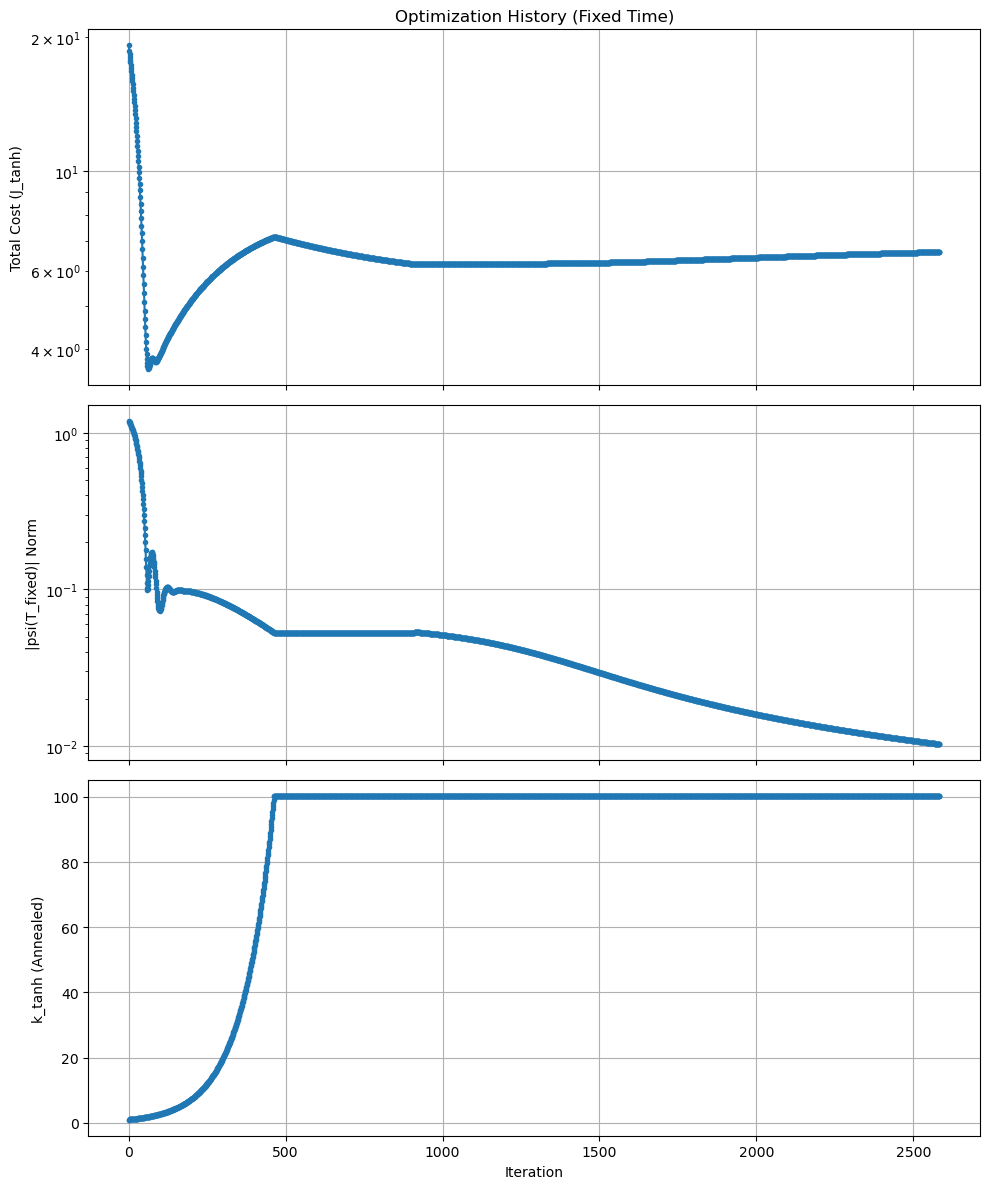

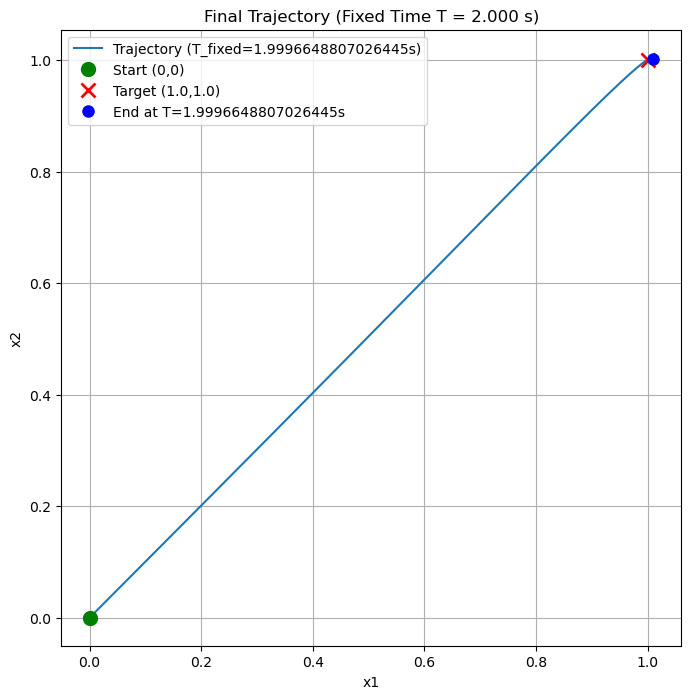

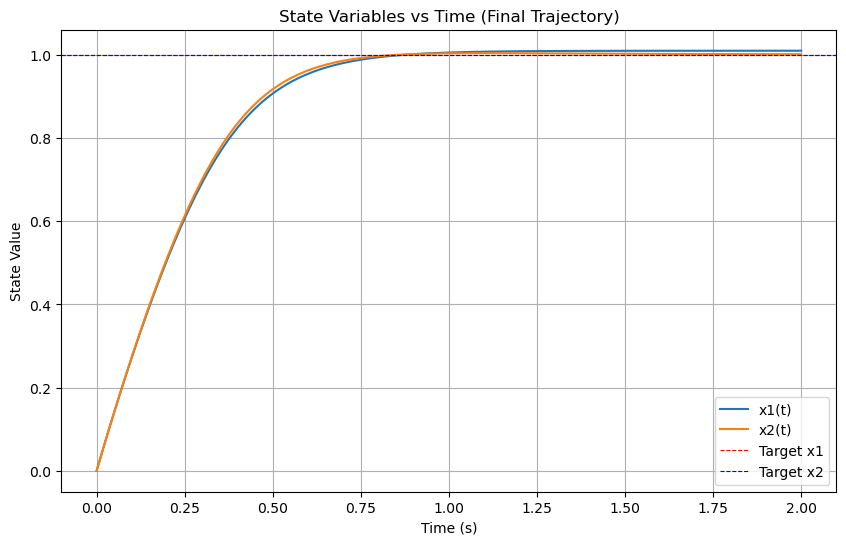

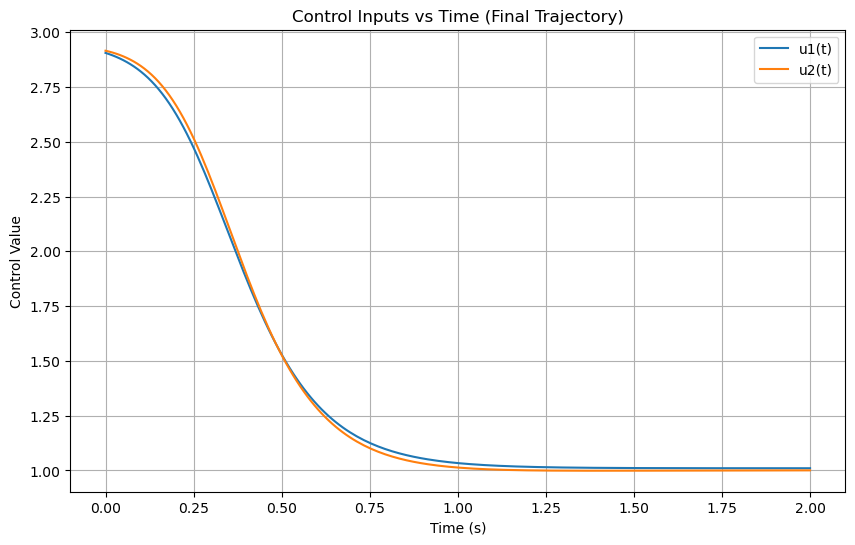

In [91]:
# --- Final Trajectory Simulation ---
print("\nSimulating final trajectory...")
with torch.no_grad():
    params_list_final = [p.clone() for p in nn_model.parameters()]
    params_flat_tensor_final = torch.cat([p.view(-1) for p in params_list_final])
    params_flat_np_final = params_flat_tensor_final.numpy()
    x0 = np.zeros(STATE_DIM)
    sol_final = solve_ivp(
        system_dynamics, [0, T_FIXED], x0,
        args=(nn_model, params_flat_np_final),
        dense_output=True, rtol=1e-6, atol=1e-7
    )


# --- Plotting ---
# 1. Cost and Constraint Violation History
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
iters = range(1, iteration + 1)
axs[0].plot(iters, history['cost'], marker='.', linestyle='-')
axs[0].set_ylabel("Total Cost (J_tanh)")
axs[0].set_title("Optimization History (Fixed Time)")
axs[0].grid(True)
axs[0].set_yscale('log')

axs[1].plot(iters, history['term_constraint_norm'], marker='.', linestyle='-')
axs[1].set_ylabel("|psi(T_fixed)| Norm")
axs[1].grid(True)
axs[1].set_yscale('log')

axs[2].plot(iters, history['k_tanh'], marker='.', linestyle='-')
axs[2].set_ylabel("k_tanh (Annealed)")
axs[2].set_xlabel("Iteration")
axs[2].grid(True)
fig.tight_layout()

# 2. Final Trajectory
t_plot = np.linspace(0, sol_final.t[-1], 200)
x_plot = sol_final.sol(t_plot)

fig_traj, ax_traj = plt.subplots(1, 1, figsize=(8, 8))
ax_traj.plot(x_plot[0, :], x_plot[1, :], label=f'Trajectory (T_fixed={T_FIXED}s)')
ax_traj.plot(x0[0], x0[1], 'go', label='Start (0,0)', markersize=10)
ax_traj.plot(TARGET_STATE[0], TARGET_STATE[1], 'rx', label=f'Target ({TARGET_STATE[0]},{TARGET_STATE[1]})', markersize=10, mew=2)
# Plot final point
ax_traj.plot(x_plot[0, -1], x_plot[1, -1], 'bo', label=f'End at T={T_FIXED}s', markersize=8)
ax_traj.set_xlabel("x1")
ax_traj.set_ylabel("x2")
ax_traj.set_title(f"Final Trajectory (Fixed Time T = {T_FIXED:.3f} s)")
ax_traj.legend()
ax_traj.grid(True)
ax_traj.axis('equal')

# Plot x1(t) and x2(t) vs time ---
fig_time, ax_time = plt.subplots(1, 1, figsize=(10, 6))
ax_time.plot(t_plot, x_plot[0, :], label='x1(t)')
ax_time.plot(t_plot, x_plot[1, :], label='x2(t)')
ax_time.axhline(TARGET_STATE[0], color='r', linestyle='--', linewidth=0.8, label='Target x1')
ax_time.axhline(TARGET_STATE[1], color='b', linestyle='--', linewidth=0.8, label='Target x2')
ax_time.set_xlabel("Time (s)")
ax_time.set_ylabel("State Value")
ax_time.set_title("State Variables vs Time (Final Trajectory)")
ax_time.legend()
ax_time.grid(True)


# Plot final u(t) vs time ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Simulate u(t) along the final trajectory
# We already have t_plot and x_plot from the final trajectory simulation
u_plot = np.zeros((CONTROL_DIM, len(t_plot)))
with torch.no_grad():
    nn_model.to(device) # Ensure model is on correct device
    for i in range(len(t_plot)):
        xi = x_plot[:, i]
        xi_t = torch.tensor(xi, dtype=torch.float32).to(device)
        ui_t = nn_model(xi_t)
        u_plot[:, i] = ui_t.cpu().numpy()

# Create the plot
fig_u_time, ax_u_time = plt.subplots(1, 1, figsize=(10, 6))
ax_u_time.plot(t_plot, u_plot[0, :], label='u1(t)')
ax_u_time.plot(t_plot, u_plot[1, :], label='u2(t)')
ax_u_time.set_xlabel("Time (s)")
ax_u_time.set_ylabel("Control Value")
ax_u_time.set_title("Control Inputs vs Time (Final Trajectory)")
ax_u_time.legend()
ax_u_time.grid(True)

plt.show()